## mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries

In [ ]:
!pip install tqdm
!pip install tensorflow_addons

In [ ]:
!pip install vit_keras

Some functions to need...

In [ ]:
#for trying out the TransUNET :0

from tensorflow.keras import layers, models
from transformers import TFAutoModel
from tensorflow.keras.layers import Dense

In [ ]:
import pickle
import numpy as np
from tqdm import tqdm
from skimage import data
from skimage import filters
from skimage import data
from skimage import filters
from scipy import ndimage
from skimage import data
from skimage import filters
import matplotlib.pyplot as plt
import pickle


def Plot_Slice(my_data,my_out,npreds,mask_scaled,LungMask,NumCase,NumSlice):

    plt.figure(figsize=(15,15))
    plt.subplot(161) # original
    plt.imshow(my_data[NumCase][0,NumSlice,:,:,0])

    plt.subplot(162) # removed
    plt.imshow(my_out[NumCase][NumSlice,:,:,0])

    plt.subplot(163) # generated mask
    plt.imshow(npreds)

    plt.subplot(164) # Real mask
    plt.imshow(mask_scaled[NumCase][0,NumSlice,:,:,0])

def sensitivityScore(label_trues, label_preds):
    sensitivities = []
    for i in range(label_trues.shape[0]):  # Iterating over each slice
        true_positives = (label_trues[i] * label_preds[i]).sum()
        possible_positives = label_trues[i].sum()
        score = (true_positives / (possible_positives + 1e-9)) if possible_positives > 0 else 0
        sensitivities.append(score)
    return np.max(sensitivities) if sensitivities else 0

def specificityScore(label_trues, label_preds):
    specificities = []
    for i in range(label_trues.shape[0]):  # Iterating over each slice
        true_negatives = ((1 - label_trues[i]) * (1 - label_preds[i])).sum()
        possible_negatives = (1 - label_trues[i]).sum()
        score = (true_negatives / (possible_negatives + 1e-9)) if possible_negatives > 0 else 0
        specificities.append(score)
    return np.max(specificities) if specificities else 0

def DiceScore(label_trues, label_preds):
    dice_scores = []
    for i in range(label_trues.shape[0]):  # Iterating over each slice
        intersection = 2 * (label_trues[i] * label_preds[i]).sum()
        sum_labels = label_trues[i].sum() + label_preds[i].sum()
        score = (intersection / (sum_labels + 1e-9)) if sum_labels > 0 else 0
        dice_scores.append(score)
    return np.max(dice_scores) if dice_scores else 0


def PlotingResults(dice_list,InfectionPercent,ScoreName=''):
    dice_list = np.array(dice_list)
    InfectionPercent = np.array(InfectionPercent)
    Data_up1per= dice_list[np.where(( (InfectionPercent> 1) ))]
    print(ScoreName,"Mean:", 100*np.array(Data_up1per)[~np.isnan(Data_up1per)].mean() ,ScoreName,"Std:", 100*np.array(Data_up1per)[~np.isnan(Data_up1per)].std() )


def EvaluateMain(my_data,my_out,mask_scaled,LungMask,Threshold,thresholdMethod,PlotingCase,PlotingSlice,PostPro):
    maxval=1
    dice_list_p = []
    sensitivity_list_p = []
    specificity_list_p = []
    InfectionPercent = []

    for i in tqdm(range(len(my_data))):
        for j in range(my_data[i].shape[1]):
            InfectionPercent.append( (100*mask_scaled[i][0,j,:,:,0].sum())/(LungMask[i][j,:,:].sum()+(10**-9)) )
            diff = my_out[i][j,:,:,0]


            # Thresholding
            npreds = (diff > Threshold*np.amax(diff)) * maxval
            # npreds = filter_isolated_cells(npreds, struct=np.ones((3,3)))

            #### Dice Scores
            dice_list_p.append(DiceScore(np.reshape(mask_scaled[i][0,j,:,:,0],(128*128)), np.reshape( npreds ,(128*128) )))

            #### Sensitivity
            sensitivity_list_p.append(sensitivityScore(np.reshape(mask_scaled[i][0,j,:,:,0],(128*128)), np.reshape( npreds ,(128*128) )))

            #### specificity
            specificity_list_p.append(specificityScore(np.reshape(mask_scaled[i][0,j,:,:,0],(128*128)), np.reshape( npreds ,(128*128) )))

    return dice_list_p ,sensitivity_list_p ,specificity_list_p ,InfectionPercent

In [ ]:
from __future__ import division
from IPython.display import clear_output

from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import ConvLSTM2D
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import Reshape
from keras.layers import UpSampling2D
from keras.models import Model
from skimage import data
from scipy import ndimage
from skimage import filters
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow_addons as tfa
import keras
import pickle


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare the data

In [ ]:
input_lung = np.load('/content/drive/MyDrive/Groupe1/input_output_gan3D/input_lung.npy')
out_gan = np.load('/content/drive/MyDrive/Groupe1/input_output_gan3D/output_lung_gen.npy')


differentiated_lung = input_lung - out_gan

print(differentiated_lung.shape)

(1600, 128, 128, 1)


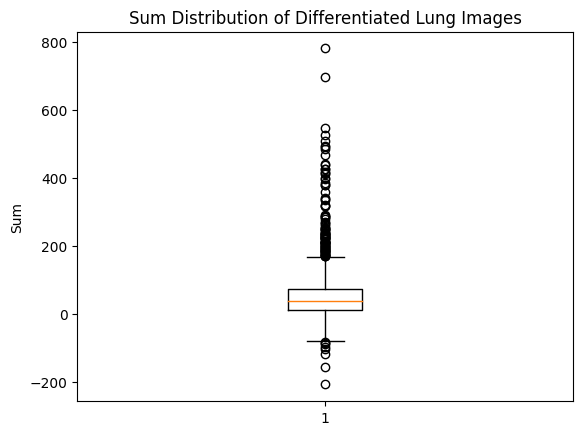

High Infection Threshold: 72.84628125151004
Low Infection Threshold: 10.115032989741366


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the 'differentiated_lung' and 'input_lung' datasets from your script
# Compute the sums for each image in 'differentiated_lung'
sums = [np.sum(differentiated_lung[i, :, :, :]) for i in range(differentiated_lung.shape[0])]

# Create a box plot to visualize the distribution
plt.boxplot(sums)
plt.title('Sum Distribution of Differentiated Lung Images')
plt.ylabel('Sum')
plt.show()

# After observing the box plot, you can manually set the thresholds
# For example, you might decide:
# - High infection threshold: Above the upper quartile
# - Low infection threshold: Between the lower quartile and the median

# Compute quartiles to help set the thresholds
Q1 = np.percentile(sums, 25)
median = np.percentile(sums, 50)
Q3 = np.percentile(sums, 75)
Q4 =  np.percentile(sums, 100)

# Set your thresholds based on the quartiles
high_infection_threshold = Q3
low_infection_threshold = Q1

print(f"High Infection Threshold: {high_infection_threshold}")
print(f"Low Infection Threshold: {low_infection_threshold}")

# You can then use these thresholds in your original code to segregate the images

In [ ]:
from tqdm import tqdm
import numpy as np

# Initialize empty arrays
x_train_hi = np.zeros((0, 128, 128, 1))
x_train_lo = np.zeros((0, 128, 128, 1))
m_train_hi = np.zeros((0, 128, 128, 1))
m_train_lo = np.zeros((0, 128, 128, 1))



# Counter variables
counter_hi = 0
counter_lo = 0


# Iterate over the differentiated_lung dataset
for i in tqdm(range(differentiated_lung.shape[0])):
    current_sum = np.sum(differentiated_lung[i, :, :, :])

    # High infection case
    if current_sum > high_infection_threshold:
        x_train_hi = np.append(x_train_hi, input_lung[i:i+1, :, :, :], axis=0)
        m_train_hi = np.append(m_train_hi, differentiated_lung[i:i+1, :, :, :], axis=0)
        counter_hi += 1

    # Low infection case
    elif low_infection_threshold   < current_sum <= high_infection_threshold:
        x_train_lo = np.append(x_train_lo, input_lung[i:i+1, :, :, :], axis=0)
        m_train_lo = np.append(m_train_lo, differentiated_lung[i:i+1, :, :, :], axis=0)
        counter_lo += 1

# Output the counts
print(f"High infection cases: {counter_hi}")
print(f"Low infection cases: {counter_lo}")

100%|██████████| 1600/1600 [00:34<00:00, 46.21it/s]

High infection cases: 400
Low infection cases: 800


In [ ]:
print(x_train_lo.shape,x_train_hi.shape)
y_train_lo = np.zeros((x_train_lo.shape[0],1))
y_train_hi = np.ones((x_train_hi.shape[0],1))

(800, 128, 128, 1) (400, 128, 128, 1)


In [ ]:
## to be balanced
x_train = np.append(x_train_hi,x_train_lo[:400],axis=0)
y_train = np.append(y_train_hi,y_train_lo[:400],axis=0)
m_train = np.append(m_train_hi,m_train_lo[:400],axis=0)

print(x_train.shape, y_train.shape, m_train.shape)

(800, 128, 128, 1) (800, 1) (800, 128, 128, 1)


## Using image data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.04),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

## Build the encoder model (UNET)



In [ ]:
def create_encoder(inputs,aug_allow='aug'):
    N = 128
    # if aug_allow == 'aug':
    #     inputs = data_augmentation(inputs)

    print(inputs.shape)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)



    up61 = layers.GlobalAveragePooling2D()(drop4_3)
    print(up61.shape, drop4_3.shape )

    return up61, drop4_3,conv1,conv2,drop3

input_size = (128,128,1)
inputs = Input(input_size)
up61,_,_,_,_ = create_encoder(inputs)
my_create_encoder = Model(inputs, up61)
my_create_encoder.summary()

(None, 128, 128, 1)
(None, 256) (None, 16, 16, 256)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                       

Building the TransUNET encoder

In [ ]:
#TO DO

## contrastive loss

In [ ]:
projection_units = 128
temperature = 0.05

In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(inputs):
    outputs = layers.Dense(projection_units, activation="relu")(inputs)
    return outputs


## Main network

In [ ]:
def batch_data(ntrain=10,ntest=10):
    trainidx1 = random.sample(range(0,int(400)), ntrain)
    trainidx2 = random.sample(range(int(400),400*2), ntrain)
    trainidx = np.append(trainidx1,trainidx2)
    XTr = x_train[trainidx,:,:,:]
    MTr = m_train[trainidx,:,:,:]
    YTr = y_train[trainidx,:]
    return XTr,MTr,YTr

In [ ]:
# from IPython import display
def plot_loss(C_losss,A_losss):
        plt.figure(figsize=(5,5))
        plt.subplot(311)

        plt.plot(C_losss, label='Contrstive loss')
        plt.legend()

        plt.subplot(312)
        plt.plot(A_losss, label='AE loss')
        plt.legend()
        plt.show()

def plot_loss2(C_losss, A_losss, S_losss):
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.plot(C_losss, label='Contrastive Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(A_losss, label='AE Loss')
    plt.legend()

    plt.subplot(133)
    plt.plot(S_losss, label='Sensitivity Enhancement Loss')
    plt.legend()

    plt.show()


def plot_sample(samples):
    for sample in samples:
        plt.figure(figsize=(10,10))
        plt.subplot(131)
        plt.imshow(x_train[sample,:,:,0])
        plt.subplot(132)
        plt.imshow(m_train[sample,:,:,0])
        plt.subplot(133)

        plt.imshow(my_en_de.predict(x_train[sample:sample+1,:,:,:])[0,:,:,0])
        plt.show()


def plot_sample2(samples, model):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for sample in samples:
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        original_img = x_train[sample, :, :, 0]
        plt.imshow(original_img, cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        mask_img = m_train[sample, :, :, 0]
        plt.imshow(mask_img, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Model Prediction
        plt.subplot(1, 3, 3)
        input_tensor = torch.from_numpy(x_train[sample:sample+1]).to(device)
        with torch.no_grad():
            prediction = model(input_tensor).cpu().numpy()[0, 0, :, :]
        plt.imshow(prediction, cmap='gray')
        plt.title("Model Prediction")
        plt.axis('off')

        plt.show()

In [ ]:
def train_en_con(inputs):
    encoder,_,_,_,_ = create_encoder(inputs,aug_allow='aug')
    encoder_with_projection_head = add_projection_head(encoder)
    return encoder_with_projection_head


In [ ]:

def train_unet(inputs, trainable=True):

    N=128
    encoder,drop4_3,conv1,conv2,drop3 = create_encoder(inputs,aug_allow='No')
    print("S", drop4_3.shape)

    up6 = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)
    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(up6)
    merge6  = concatenate([x1,x2], axis = 1)
    merge6 = ConvLSTM2D(filters = 64, kernel_size=(2, 2), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal')(merge6)

    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(up7)
    print(x2.shape)
    merge7  = concatenate([x1,x2], axis = 1)
    merge7 = ConvLSTM2D(filters = 32, kernel_size=(2, 2), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)

    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(32, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)

    x1 = Reshape(target_shape=(1, N, N, 32))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 32))(up8)
    merge8  = concatenate([x1,x2], axis = 1)
    merge8 = ConvLSTM2D(filters = 16, kernel_size=(2, 2), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)

    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'tanh')(conv8)
    return conv9





input_size = (128,128,1)
inputs = Input(input_size)
en_de = train_unet(inputs)
my_en_de = Model(inputs, en_de)
my_en_de.summary()

encoded = train_en_con(inputs)
my_train_en_con = Model(inputs, encoded)
my_train_en_con.summary()


(None, 128, 128, 1)
(None, 256) (None, 16, 16, 256)
S (None, 16, 16, 256)
(None, 1, 64, 64, 64)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 128, 128, 32)         320       ['input_2[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_12[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)           0         ['conv2d_13[0][0]']        

In [ ]:

# Define the parameters for the learning rate schedule
initial_learning_rate = 0.00005
decay_steps = 1000
decay_rate = 0.9
# Create a learning rate schedule using ExponentialDecay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False  # Set to True if you want a staircase-like decay
)

# Create an optimizer for my_en_de model
g_opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)
my_en_de.compile(loss='mse', optimizer=g_opt)

# Use the same learning rate for my_train_en_con
my_train_en_con.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
    metrics='Accuracy'
)

In [ ]:
def train_for_n(nb_epoch, plt_frq,ntrain):
    C_losss = []
    A_losss = []
    for e in (range(nb_epoch)):
        print(e,end='')
        for _ in range(2):
            XTr,MTr,YTr = batch_data(ntrain=4)
            C_loss,_ = my_train_en_con.train_on_batch(XTr,YTr)

        XTr,MTr,YTr = batch_data(ntrain=4)
        A_loss = my_en_de.train_on_batch(XTr,MTr)

        C_losss.append(C_loss)
        A_losss.append(A_loss)


        # Updates plots
        if e%plt_frq==plt_frq-1:
            my_train_en_con.save('/content/drive/MyDrive/Groupe1/en_de_2D/my_train_en_con', save_format='h5')
            my_en_de.save('/content/drive/MyDrive/Groupe1/en_de_2D/my_en_de', save_format='h5')
            clear_output()
            plot_loss(C_losss,A_losss)
            plot_sample([90, 100, 200])



In [ ]:
tf.config.run_functions_eagerly(True)

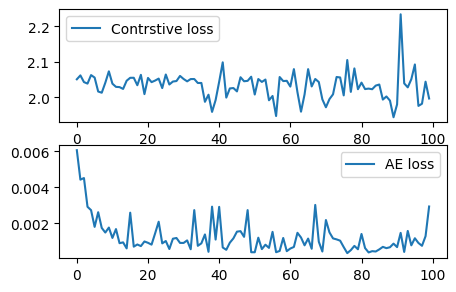

1/1 [==============================] - 0s 102ms/step


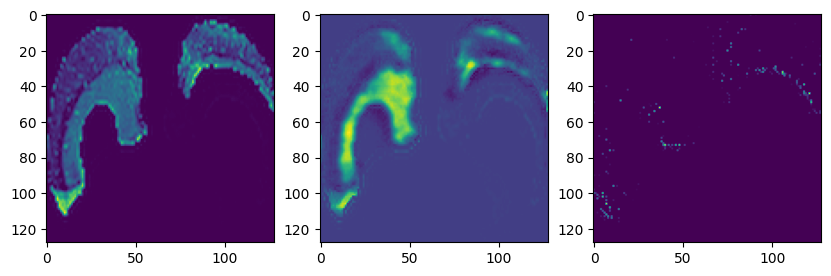

1/1 [==============================] - 0s 110ms/step


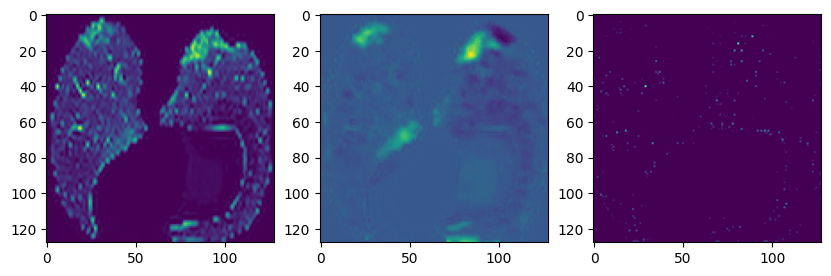

1/1 [==============================] - 0s 107ms/step


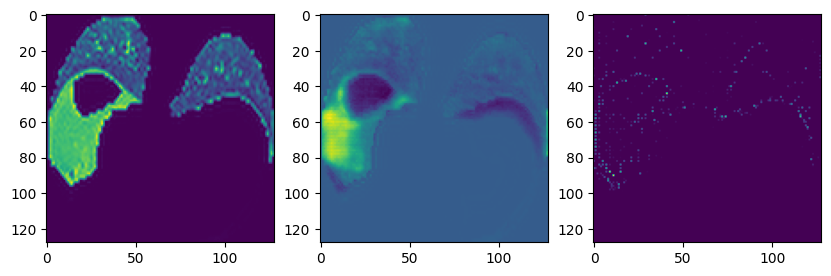

In [ ]:
train_for_n(nb_epoch=100,
            plt_frq=2,
            ntrain=8)

## check the result on CoronaCases dataset

In [ ]:
### load the model
import keras
BCDU_net_D3_model = keras.models.load_model('/content/drive/MyDrive/Groupe1/en_de_2D/my_en_de')
BCDU_net_D3_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 128, 128, 32)         320       ['input_2[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_12[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)           0         ['conv2d_13[0][0]']           
 g2D)                                                                                       

In [ ]:
#### calculate the output of model
def OutPutModel(my_data):
    my_out = []
    for i in tqdm(range(len(my_data))):


        my_out.append(BCDU_net_D3_model.predict(my_data[i][0,:,:,:]))



    return my_out




def Add_Dim(data):
    ################## add a dim to data
    data_scaled = []
    for j in tqdm(range(len(data))):

            output = np.zeros((1,data[j].shape[0],data[j].shape[1],data[j].shape[2],1))
            output[0,:,:,:,0] = data[j][:,:,:]
            data_scaled.append(output)
    return data_scaled



def LoadData(DatasetName):

    ############## Load
    if(DatasetName=='Mosmed_Dataset'):
        Base_data = np.load('/content/drive/MyDrive/Groupe1/preprocessed_data/BaseCTImages.npy')

        data = np.load('/content/drive/MyDrive/Groupe1/preprocessed_data/LungImages.npy')


        mask = np.load('/content/drive/MyDrive/Groupe1/preprocessed_data/InfectionMasks.npy')

        LungMask = np.load('/content/drive/MyDrive/Groupe1/preprocessed_data/LungMask.npy')

        for i in range(mask.shape[0]):
            mask[i,:,:,:]=np.where(mask[i,:,:,:]>0.3,1,0)
            LungMask[i,:,:,:]=np.where(LungMask[i,:,:,:]>0.0001,1,0)



    ####################### Add a dim
    ########### add a dim to data
    Data_scaled = Add_Dim(data)


    ########### add a dim to mask
    mask_scaled = Add_Dim(mask)

    ### get output of model
    my_out = OutPutModel(Data_scaled)



    return Data_scaled,my_out, mask_scaled, LungMask


In [ ]:
#### upload data
my_data, my_out, mask_scaled, LungMask = LoadData("Mosmed_Dataset")


####### Calculating the evaluation metrics(Dice score, Specificity, Sensitivity )
dice_list, sensitivity_list, specificity_list, InfectionPercent = EvaluateMain(my_data,my_out,mask_scaled,LungMask,Threshold= 0.2,thresholdMethod='1',
                                                                                      PlotingCase=10,PlotingSlice=15,PostPro=False)

############### ploting resuts

### Dice score
PlotingResults(dice_list ,InfectionPercent,ScoreName='Dice score')

##### Sensitivity
PlotingResults(sensitivity_list,InfectionPercent,ScoreName='Sensitivity')


##### Specificity
PlotingResults(specificity_list,InfectionPercent,ScoreName='specificity')



  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 267ms/step


  2%|▏         | 1/50 [00:00<00:15,  3.14it/s]

1/1 [==============================] - 0s 219ms/step


  4%|▍         | 2/50 [00:00<00:13,  3.46it/s]

1/1 [==============================] - 0s 214ms/step


  6%|▌         | 3/50 [00:00<00:12,  3.62it/s]

1/1 [==============================] - 0s 218ms/step


  8%|▊         | 4/50 [00:01<00:12,  3.68it/s]

1/1 [==============================] - 0s 216ms/step


 10%|█         | 5/50 [00:01<00:12,  3.73it/s]

1/1 [==============================] - 0s 218ms/step


 12%|█▏        | 6/50 [00:01<00:11,  3.75it/s]

1/1 [==============================] - 0s 214ms/step


 14%|█▍        | 7/50 [00:01<00:11,  3.78it/s]

1/1 [==============================] - 0s 218ms/step


 16%|█▌        | 8/50 [00:02<00:11,  3.79it/s]

1/1 [==============================] - 0s 215ms/step


 18%|█▊        | 9/50 [00:02<00:10,  3.78it/s]

1/1 [==============================] - 0s 217ms/step


 20%|██        | 10/50 [00:02<00:10,  3.78it/s]

1/1 [==============================] - 0s 215ms/step


 22%|██▏       | 11/50 [00:02<00:10,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


 24%|██▍       | 12/50 [00:03<00:10,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


 26%|██▌       | 13/50 [00:03<00:09,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


 28%|██▊       | 14/50 [00:03<00:09,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


 30%|███       | 15/50 [00:04<00:09,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


 32%|███▏      | 16/50 [00:04<00:08,  3.81it/s]

1/1 [==============================] - 0s 215ms/step


 34%|███▍      | 17/50 [00:04<00:08,  3.81it/s]

1/1 [==============================] - 0s 216ms/step


 36%|███▌      | 18/50 [00:04<00:08,  3.81it/s]

1/1 [==============================] - 0s 218ms/step


 38%|███▊      | 19/50 [00:05<00:08,  3.78it/s]

1/1 [==============================] - 0s 218ms/step


 40%|████      | 20/50 [00:05<00:07,  3.78it/s]

1/1 [==============================] - 0s 219ms/step


 42%|████▏     | 21/50 [00:05<00:07,  3.77it/s]

1/1 [==============================] - 0s 216ms/step


 44%|████▍     | 22/50 [00:05<00:07,  3.78it/s]

1/1 [==============================] - 0s 215ms/step


 46%|████▌     | 23/50 [00:06<00:07,  3.79it/s]

1/1 [==============================] - 0s 216ms/step


 48%|████▊     | 24/50 [00:06<00:06,  3.80it/s]

1/1 [==============================] - 0s 218ms/step


 50%|█████     | 25/50 [00:06<00:06,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


 52%|█████▏    | 26/50 [00:06<00:06,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


 54%|█████▍    | 27/50 [00:07<00:06,  3.78it/s]

1/1 [==============================] - 0s 216ms/step


 56%|█████▌    | 28/50 [00:07<00:05,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


 58%|█████▊    | 29/50 [00:07<00:05,  3.79it/s]

1/1 [==============================] - 0s 216ms/step


 60%|██████    | 30/50 [00:07<00:05,  3.79it/s]

1/1 [==============================] - 0s 219ms/step


 62%|██████▏   | 31/50 [00:08<00:05,  3.78it/s]

1/1 [==============================] - 0s 217ms/step


 64%|██████▍   | 32/50 [00:08<00:04,  3.78it/s]

1/1 [==============================] - 0s 215ms/step


 66%|██████▌   | 33/50 [00:08<00:04,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


 68%|██████▊   | 34/50 [00:09<00:04,  3.79it/s]

1/1 [==============================] - 0s 219ms/step


 70%|███████   | 35/50 [00:09<00:04,  3.72it/s]

1/1 [==============================] - 0s 218ms/step


 72%|███████▏  | 36/50 [00:09<00:03,  3.71it/s]

1/1 [==============================] - 0s 218ms/step


 74%|███████▍  | 37/50 [00:09<00:03,  3.72it/s]

1/1 [==============================] - 0s 219ms/step


 76%|███████▌  | 38/50 [00:10<00:03,  3.74it/s]

1/1 [==============================] - 0s 220ms/step


 78%|███████▊  | 39/50 [00:10<00:02,  3.74it/s]

1/1 [==============================] - 0s 217ms/step


 80%|████████  | 40/50 [00:10<00:02,  3.72it/s]

1/1 [==============================] - 0s 217ms/step


 82%|████████▏ | 41/50 [00:10<00:02,  3.75it/s]

1/1 [==============================] - 0s 218ms/step


 84%|████████▍ | 42/50 [00:11<00:02,  3.75it/s]

1/1 [==============================] - 0s 218ms/step


 86%|████████▌ | 43/50 [00:11<00:01,  3.76it/s]

1/1 [==============================] - 0s 216ms/step


 88%|████████▊ | 44/50 [00:11<00:01,  3.73it/s]

1/1 [==============================] - 0s 215ms/step


 90%|█████████ | 45/50 [00:11<00:01,  3.76it/s]

1/1 [==============================] - 0s 216ms/step


 92%|█████████▏| 46/50 [00:12<00:01,  3.78it/s]

1/1 [==============================] - 0s 216ms/step


 94%|█████████▍| 47/50 [00:12<00:00,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


 96%|█████████▌| 48/50 [00:12<00:00,  3.79it/s]

1/1 [==============================] - 0s 216ms/step


 98%|█████████▊| 49/50 [00:13<00:00,  3.80it/s]

1/1 [==============================] - 0s 218ms/step


100%|██████████| 50/50 [07:04<00:00,  8.49s/it]

Dice score Mean: 67.88990822293577 Dice score Std: 46.68994731610263
Sensitivity Mean: 67.88990818899082 Sensitivity Std: 46.68994729275766
specificity Mean: 99.63302742330276 specificity Std: 6.046699830020852


In [ ]:
!pip list

In [ ]:
!pip install einops


IMplementing TransUNET

utilis.py

In [ ]:
import torch
import numpy as np


def thresh_func(mask, thresh=0.5):
    mask[mask >= thresh] = 1
    mask[mask < thresh] = 0

    return mask


def dice_loss(pred, target):
    pred = torch.sigmoid(pred)

    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)

    intersection = torch.sum(pred * target)
    pred_sum = torch.sum(pred * pred)
    target_sum = torch.sum(target * target)

    return 1 - ((2. * intersection + 1e-5) / (pred_sum + target_sum + 1e-5))


class EpochCallback:
    end_training = False
    not_improved_epoch = 0
    monitor_value = np.inf

    def __init__(self, model_name, total_epoch_num, model, optimizer, monitor=None, patience=None):
        if isinstance(model_name, str):
            model_name = [model_name]
            model = [model]
            optimizer = [optimizer]

        self.model_name = model_name
        self.total_epoch_num = total_epoch_num
        self.monitor = monitor
        self.patience = patience
        self.model = model
        self.optimizer = optimizer

    def __save_model(self):
        for m_name, m, opt in zip(self.model_name, self.model, self.optimizer):
            torch.save({'model_state_dict': m.state_dict(),
                        'optimizer_state_dict': opt.state_dict()},
                       m_name)

            print(f'Model saved to {m_name}')

    def epoch_end(self, epoch_num, hash):
        epoch_end_str = f'Epoch {epoch_num}/{self.total_epoch_num} - '
        for name, value in hash.items():
            epoch_end_str += f'{name}: {round(value, 4)} '

        print(epoch_end_str)

        if self.monitor is None:
            self.__save_model()

        elif hash[self.monitor] < self.monitor_value:
            print(f'{self.monitor} decreased from {round(self.monitor_value, 4)} to {round(hash[self.monitor], 4)}')

            self.not_improved_epoch = 0
            self.monitor_value = hash[self.monitor]
            self.__save_model()
        else:
            print(f'{self.monitor} did not decrease from {round(self.monitor_value, 4)}, model did not save!')

            self.not_improved_epoch += 1
            if self.patience is not None and self.not_improved_epoch >= self.patience:
                print("Training was stopped by callback!")
                self.end_training = True

ViT.py

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange, repeat


class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, head_num):
        super().__init__()

        self.head_num = head_num
        self.dk = (embedding_dim // head_num) ** (1 / 2)

        self.qkv_layer = nn.Linear(embedding_dim, embedding_dim * 3, bias=False)
        self.out_attention = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x, mask=None):
        qkv = self.qkv_layer(x)

        query, key, value = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.head_num))
        energy = torch.einsum("... i d , ... j d -> ... i j", query, key) * self.dk

        if mask is not None:
            energy = energy.masked_fill(mask, -np.inf)

        attention = torch.softmax(energy, dim=-1)

        x = torch.einsum("... i j , ... j d -> ... i d", attention, value)

        x = rearrange(x, "b h t d -> b t (h d)")
        x = self.out_attention(x)

        return x


class MLP(nn.Module):
    def __init__(self, embedding_dim, mlp_dim):
        super().__init__()

        self.mlp_layers = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_dim, embedding_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        x = self.mlp_layers(x)

        return x


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim):
        super().__init__()

        self.multi_head_attention = MultiHeadAttention(embedding_dim, head_num)
        self.mlp = MLP(embedding_dim, mlp_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        _x = self.multi_head_attention(x)
        _x = self.dropout(_x)
        x = x + _x
        x = self.layer_norm1(x)

        _x = self.mlp(x)
        x = x + _x
        x = self.layer_norm2(x)

        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim, block_num=12):
        super().__init__()

        self.layer_blocks = nn.ModuleList(
            [TransformerEncoderBlock(embedding_dim, head_num, mlp_dim) for _ in range(block_num)])

    def forward(self, x):
        for layer_block in self.layer_blocks:
            x = layer_block(x)

        return x


class ViT(nn.Module):
    def __init__(self, img_dim, in_channels, embedding_dim, head_num, mlp_dim,
                 block_num, patch_dim, classification=True, num_classes=1):
        super().__init__()

        self.patch_dim = patch_dim
        self.classification = classification
        self.num_tokens = (img_dim // patch_dim) ** 2
        self.token_dim = in_channels * (patch_dim ** 2)

        self.projection = nn.Linear(self.token_dim, embedding_dim)
        self.embedding = nn.Parameter(torch.rand(self.num_tokens + 1, embedding_dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        self.dropout = nn.Dropout(0.1)

        self.transformer = TransformerEncoder(embedding_dim, head_num, mlp_dim, block_num)

        if self.classification:
            self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        img_patches = rearrange(x,
                                'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.patch_dim, patch_y=self.patch_dim)

        batch_size, tokens, _ = img_patches.shape

        project = self.projection(img_patches)
        token = repeat(self.cls_token, 'b ... -> (b batch_size) ...',
                       batch_size=batch_size)

        patches = torch.cat([token, project], dim=1)
        patches += self.embedding[:tokens + 1, :]

        x = self.dropout(patches)
        x = self.transformer(x)
        x = self.mlp_head(x[:, 0, :]) if self.classification else x[:, 1:, :]

        return x


if __name__ == '__main__':
    vit = ViT(img_dim=128,
              in_channels=1,
              patch_dim=16,
              embedding_dim=512,
              block_num=6,
              head_num=4,
              mlp_dim=1024)


<ipython-input-32-3877f8339bdc>:160: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print(np.sum(p.numel() for p in transunet.parameters()))


66870129
shape (128, 128, 1)
yooo-1 torch.Size([128, 128, 1])
TransUNET output torch.Size([1, 1, 128, 128])
(128, 128, 1)


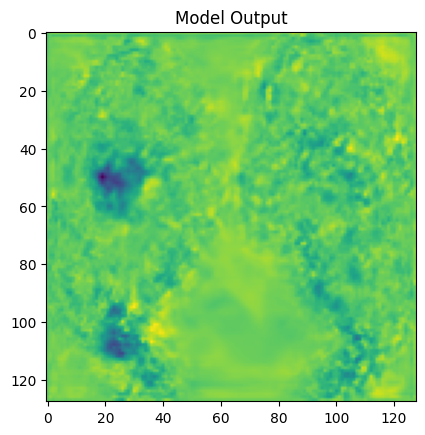

In [ ]:
import torch
import torch.nn as nn
from einops import rearrange



class EncoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, base_width=64):
        super().__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        width = int(out_channels * (base_width / 64))

        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1, stride=1, bias=False)
        self.norm1 = nn.BatchNorm2d(width)

        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=2, groups=1, padding=1, dilation=1, bias=False)
        self.norm2 = nn.BatchNorm2d(width)

        self.conv3 = nn.Conv2d(width, out_channels, kernel_size=1, stride=1, bias=False)
        self.norm3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_down = self.downsample(x)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = x + x_down
        x = self.relu(x)

        return x


class DecoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, x_concat=None):
        x = self.upsample(x)

        if x_concat is not None:
            x = torch.cat([x_concat, x], dim=1)

        x = self.layer(x)
        return x


class Encoder(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.encoder1 = EncoderBottleneck(out_channels, out_channels * 2, stride=2)
        self.encoder2 = EncoderBottleneck(out_channels * 2, out_channels * 4, stride=2)
        self.encoder3 = EncoderBottleneck(out_channels * 4, out_channels * 8, stride=2)

        self.vit_img_dim = img_dim // patch_dim
        self.vit = ViT(self.vit_img_dim, out_channels * 8, out_channels * 8,
                       head_num, mlp_dim, block_num, patch_dim=1, classification=False)

        self.conv2 = nn.Conv2d(out_channels * 8, 512, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(512)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x1 = self.relu(x)

        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x = self.encoder3(x3)

        x = self.vit(x)
        x = rearrange(x, "b (x y) c -> b c x y", x=self.vit_img_dim, y=self.vit_img_dim)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        return x, x1, x2, x3


class Decoder(nn.Module):
    def __init__(self, out_channels, class_num):
        super().__init__()

        self.decoder1 = DecoderBottleneck(out_channels * 8, out_channels * 2)
        self.decoder2 = DecoderBottleneck(out_channels * 4, out_channels)
        self.decoder3 = DecoderBottleneck(out_channels * 2, int(out_channels * 1 / 2))
        self.decoder4 = DecoderBottleneck(int(out_channels * 1 / 2), int(out_channels * 1 / 8))

        self.conv1 = nn.Conv2d(int(out_channels * 1 / 8), class_num, kernel_size=1)

    def forward(self, x, x1, x2, x3):
        x = self.decoder1(x, x3)
        x = self.decoder2(x, x2)
        x = self.decoder3(x, x1)
        x = self.decoder4(x)
        x = self.conv1(x)

        return x


class TransUNet(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim, class_num):
        super().__init__()

        self.encoder = Encoder(img_dim, in_channels, out_channels,
                               head_num, mlp_dim, block_num, patch_dim)

        self.decoder = Decoder(out_channels, class_num)

    def forward(self, x):
        x, x1, x2, x3 = self.encoder(x)
        x = self.decoder(x, x1, x2, x3)


        return x


if __name__ == '__main__':
    import torch

    transunet = TransUNet(img_dim=128,
                          in_channels=1,
                          out_channels=128,
                          head_num=4,
                          mlp_dim=512,
                          block_num=8,
                          patch_dim=16,
                          class_num=1)

    print(np.sum(p.numel() for p in transunet.parameters()))
    # Ensure the input is a torch tensor and reshape it
    print("shape", x_train[2].shape)
    sample_input = torch.tensor(x_train[2], dtype=torch.float32)
    print("yooo-1",sample_input.shape )
    if len(sample_input.shape) == 3:
        sample_input = sample_input.unsqueeze(0)  # Add batch dimension if necessary
    sample_input = sample_input.permute(0, 3, 1, 2)  # Reshape from [B, H, W, C] to [B, C, H, W]

    # Forward pass through the model
    output = transunet(sample_input)
    print("TransUNET output", output.shape)

        # Convert the output tensor to a NumPy array
    # Assuming the output is a single image or you're interested in the first one
    output_np = output.cpu().detach().numpy()[0]  # Convert first image of the batch
    output_np = np.moveaxis(output_np, 0, -1)  # Rearrange from [C, H, W] to [H, W, C]

    # Rescale the output to [0, 1] if necessary
    # This step depends on how your model processes the output. You might need to adjust it.
    output_np = (output_np - output_np.min()) / (output_np.max() - output_np.min())

    print(output_np.shape)

    # Plot the output image
    plt.imshow(output_np)  # Adjust color map as needed
    plt.title("Model Output")
    plt.show()

In [ ]:

def batch_data3(ntrain=10, ntest=10):
    trainidx1 = random.sample(range(0, int(116)), ntrain)
    trainidx2 = random.sample(range(int(116), 116*2), ntrain)
    trainidx = np.append(trainidx1, trainidx2)

    XTr = torch.tensor(x_train[trainidx], dtype=torch.float32).permute(0, 3, 1, 2)  # [N, H, W, C] to [N, C, H, W]
    MTr = torch.tensor(m_train[trainidx], dtype=torch.float32).permute(0, 3, 1, 2)  # Same for masks
    YTr = torch.tensor(y_train[trainidx], dtype=torch.float32).view(-1, 1, 1, 1)  # Assuming YTr is already in the correct shape

    return XTr, MTr, YTr

def plot_sample2(model, samples, x_train=x_train, m_train=m_train):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for sample in samples:
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        original_img = x_train[sample, :, :, 0]
        plt.imshow(original_img)
        plt.title("Original Image")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        mask_img = m_train[sample, :, :, 0]
        plt.imshow(mask_img)
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Model Prediction
        plt.subplot(1, 3, 3)
        input_tensor = (torch.tensor(x_train[sample:sample+1], dtype=torch.float32)).permute(0, 3, 1, 2).to(device)
        with torch.no_grad():
            prediction = model(input_tensor).cpu().numpy()[0, 0, :, :]
        plt.imshow(prediction)
        plt.title("Model Prediction")
        plt.axis('off')

        plt.show()

In [ ]:
import torch.nn.functional as F  # Import the functional module


class SupervisedContrastiveLossAdapated(nn.Module):
    def __init__(self, temperature=1.0):
        super(SupervisedContrastiveLossAdapated, self).__init__()
        self.temperature = temperature

    def forward(self, feature_vectors, labels):
        # Flatten the feature vectors while preserving the batch dimension
        feature_vectors_flattened = feature_vectors.view(feature_vectors.size(0), -1)

        # Normalize the feature vectors
        feature_vectors_normalized = F.normalize(feature_vectors_flattened, p=2, dim=1)

        # Compute the logits
        logits = torch.matmul(feature_vectors_normalized, feature_vectors_normalized.transpose(0, 1)) / self.temperature

        # Reshape labels to 1D tensor, convert to long, and ensure they are on the same device as logits
        labels = labels.view(-1).long().to(logits.device)

        # Compute similarity matrix
        similarity_matrix = torch.exp(logits)

        # Create mask for positive pairs and compute positive similarities
        positive_mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float()
        positive_similarity = torch.sum(similarity_matrix * positive_mask, dim=1)

        # Create mask for negative pairs and compute negative similarities
        negative_mask = 1 - positive_mask
        negative_similarity = torch.sum(similarity_matrix * negative_mask, dim=1)

        # Compute the final loss
        loss = -torch.log(positive_similarity / (positive_similarity + negative_similarity + 1e-9))
        return loss.mean()



import torch
import torch.nn.functional as F
import torch.nn as nn

class EnhancedContrastiveLoss(nn.Module):
    def __init__(self, temperature=1.0, sensitivity_weight=1.5):
        super(EnhancedContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.sensitivity_weight = sensitivity_weight

    def forward(self, feature_vectors, labels):
        # Flatten the feature vectors while preserving the batch dimension
        feature_vectors_flattened = feature_vectors.view(feature_vectors.size(0), -1)

        # Normalize the feature vectors
        feature_vectors_normalized = F.normalize(feature_vectors_flattened, p=2, dim=1)

        # Compute the logits
        logits = torch.matmul(feature_vectors_normalized, feature_vectors_normalized.transpose(0, 1)) / self.temperature

        # Reshape labels to 1D tensor, convert to long, and ensure they are on the same device as logits
        labels = labels.view(-1).long().to(logits.device)

        # Compute similarity matrix
        similarity_matrix = torch.exp(logits)

        # Create masks for positive and negative pairs
        positive_mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float()
        negative_mask = 1 - positive_mask

        # Compute positive and negative similarities
        positive_similarity = torch.sum(similarity_matrix * positive_mask, dim=1)
        negative_similarity = torch.sum(similarity_matrix * negative_mask, dim=1)

        # Adjust the weight of positive similarities to enhance sensitivity
        weighted_positive_similarity = positive_similarity * self.sensitivity_weight

        # Compute the final loss
        loss = -torch.log(weighted_positive_similarity / (weighted_positive_similarity + negative_similarity + 1e-9))
        return loss.mean()

class SensitivityEnhancedLoss(nn.Module):
    def __init__(self, beta=2.0):
        super(SensitivityEnhancedLoss, self).__init__()
        self.beta = beta

    def forward(self, predictions, targets):
        # Calculate the binary cross-entropy loss
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(predictions, targets)

        # Identify the false negatives
        false_negatives = (1 - predictions.sigmoid()) * targets

        # Increase the weight of false negatives in the loss
        enhanced_loss = bce_loss * (1 + false_negatives * self.beta)
        return enhanced_loss.mean()


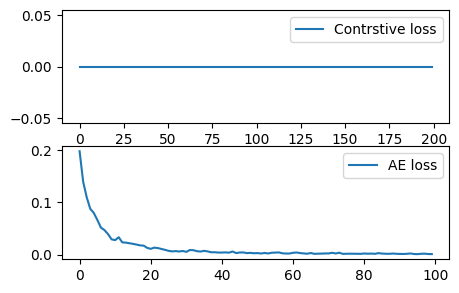

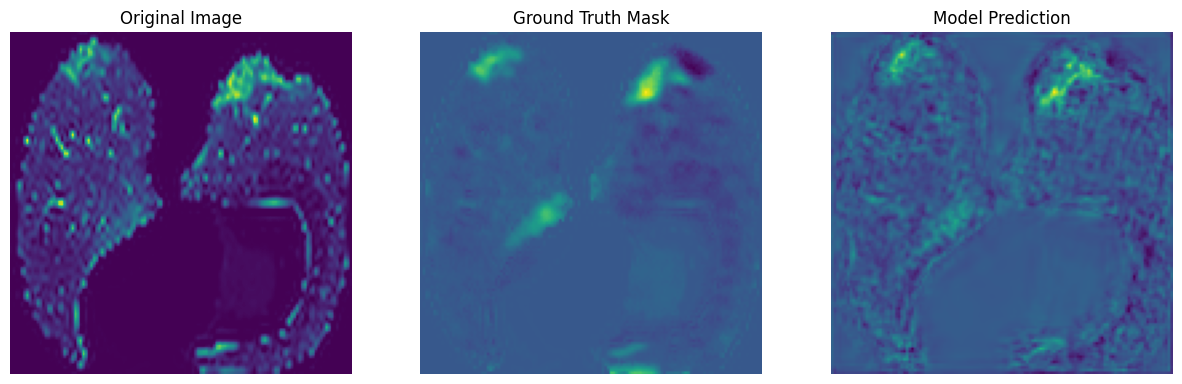

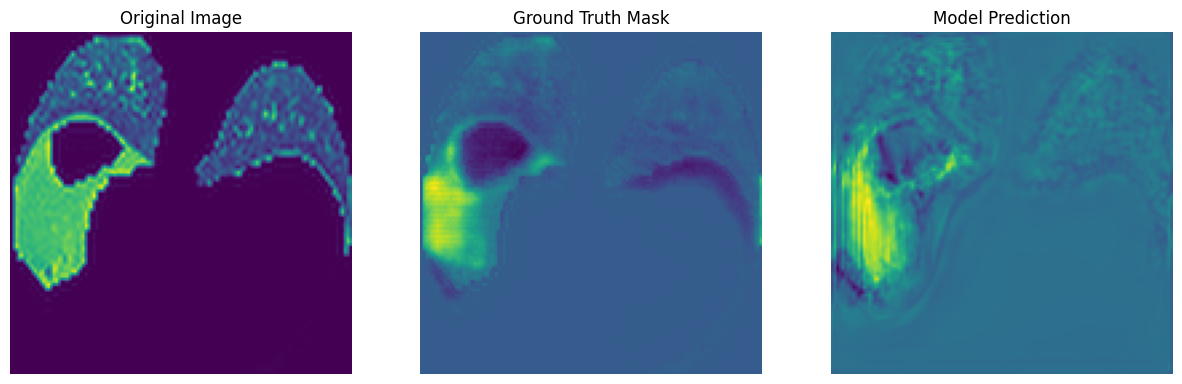

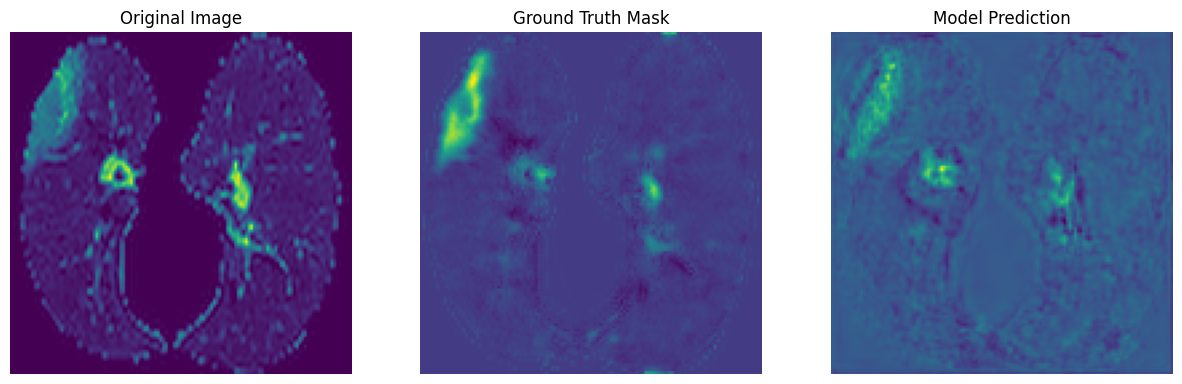

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from IPython.display import clear_output
from tqdm import tqdm

from torch.optim.lr_scheduler import ReduceLROnPlateau

transunet = TransUNet(
    img_dim=128,
    in_channels=1,
    out_channels=128,
    head_num=4,
    mlp_dim=512,
    block_num=8,
    patch_dim=16,
    class_num=1
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
contrastive_criterion = EnhancedContrastiveLoss()
optimizer = optim.Adam(transunet.parameters(), lr=0.00005)




def train_for_n(model, epochs, plot_freq, batch_data, optimizer, contrastive_criterion, mse_criterion, save_path, sample_indices):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    C_losss = []
    A_losss = []

    for epoch in range(epochs):
        model.train()
        for _ in range(2):  # Entraînement contrastif
            XTr, MTr, YTr = batch_data3(ntrain=4)
            XTr = XTr.to(device)
            YTr = YTr.to(device)
            MTr = MTr.to(device)

            print(XTr.shape)

            optimizer.zero_grad()
            features = model(XTr)



            C_loss = contrastive_criterion(features, YTr)
            C_loss.backward()
            optimizer.step()
            C_losss.append(C_loss.item())

        # Entraînement MSE
        XTr, MTr, _ = batch_data3(ntrain=4)
        XTr = XTr.to(device)
        MTr = MTr.to(device)

        optimizer.zero_grad()
        output = model(XTr)
        A_loss = mse_criterion(output, MTr)
        A_loss.backward()
        optimizer.step()
        A_losss.append(A_loss.item())

        # Mise à jour des graphiques et sauvegarde du modèle
        if (epoch + 1) % plot_freq == 0:
            clear_output(wait=True)
            plot_loss(C_losss, A_losss)
            plot_sample2(model, sample_indices)  # Plot sample images
        torch.save(model.state_dict(), f'{save_path}/final_model_transUNET.pt')





# Exemple d'utilisation
# train_for_n2(transunet, epochs=100, plot_freq=2, batch_data=batch_data3, initial_temperature=1.0, save_path='/content/drive/MyDrive/Groupe1/en_de_2D/', sample_indices=[100, 200, 300])
train_for_n(transunet, epochs=100, plot_freq=2, batch_data=batch_data3, optimizer = optimizer, contrastive_criterion =contrastive_criterion, mse_criterion = nn.MSELoss(), save_path='/content/drive/MyDrive/Groupe1/en_de_2D/', sample_indices=[100, 200, 300])


def train_for_n(model, epochs, plot_freq, batch_data, optimizer, contrastive_criterion, mse_criterion, sensitivity_criterion, save_path, sample_indices):

    model.to(device)

    C_losss = []
    A_losss = []
    S_losss = []  # Sensitivity losses

    for epoch in range(epochs):
        model.train()
        for _ in range(2):  # Entraînement contrastif
            XTr, MTr, YTr = batch_data3(ntrain=4)
            XTr, MTr, YTr = XTr.to(device), MTr.to(device), YTr.to(device)

            optimizer.zero_grad()
            output = model(XTr)

            # Compute the standard losses
            C_loss = contrastive_criterion(output, YTr)
            A_loss = mse_criterion(output, MTr)

            # Compute the sensitivity-enhanced loss
            S_loss = sensitivity_criterion(output, MTr)

            # Combine the losses
            total_loss = C_loss + A_loss + S_loss

            # Backward and optimize
            total_loss.backward()
            optimizer.step()

            C_losss.append(C_loss.item())
            A_losss.append(A_loss.item())
            S_losss.append(S_loss.item())

        if (epoch + 1) % plot_freq == 0:
            clear_output(wait=True)
            plot_loss2(C_losss, A_losss, S_losss)
            plot_sample2(model, sample_indices)

        torch.save(model.state_dict(), f'{save_path}/final_model_transUNET.pt')

    return C_losss, A_losss, S_losss

# Example usage
sensitivity_criterion = SensitivityEnhancedLoss(beta=2.0)
train_for_n(transunet, epochs=500, plot_freq=2, batch_data=batch_data3, optimizer=optimizer, contrastive_criterion=contrastive_criterion, mse_criterion=nn.MSELoss(), sensitivity_criterion=sensitivity_criterion, save_path='/content/drive/MyDrive/Groupe1/en_de_2D/', sample_indices=[100, 200, 300])


In [ ]:
import numpy as np
import torch
from tqdm import tqdm


# Load the TransGAN model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transunet_model = TransUNet(
    img_dim=128,
    in_channels=1,
    out_channels=128,
    head_num=4,
    mlp_dim=512,
    block_num=8,
    patch_dim=16,
    class_num=1
).to(device)

# Load the weights from the checkpoint
checkpoint_path = "/content/drive/MyDrive/Groupe1/en_de_2D/final_model_transUNET.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
transunet_model.load_state_dict(checkpoint)

# Set the model to evaluation mode
transunet_model.eval()



def Add_Dim(data):
    ################## add a dim to data
    data_scaled = []
    for j in tqdm(range(len(data))):
            output = np.zeros((1,data[j].shape[0],data[j].shape[1],data[j].shape[2],1))
            output[0,:,:,:,0] = data[j][:,:,:]
            data_scaled.append(output)

    print("OOOO", data_scaled[0].shape)
    return data_scaled

# Define a function to calculate the output of the TransGAN model
def output_model2(my_data, model, device):
    my_out = []

    for batch in tqdm(my_data):
        # Initialize a container for the current batch's outputs
        batch_outputs = np.zeros((batch.shape[1], 128, 128, 1))  # Shape: (32, 128, 128, 1)

        # Each batch in my_data is of shape (1, 32, 128, 128, 1)
        for i in range(batch.shape[1]):  # Iterate over the slices (32 in this case)
            # Extract the ith slice, resulting in shape (128, 128, 1)
            A = batch[0, i, :, :, :]

            # Convert to PyTorch tensor and reshape
            A = torch.tensor(A, dtype=torch.float32)
            A = A.permute(2, 0, 1).unsqueeze(0)  # Change to (B, C, H, W) format

            # Forward pass through the model
            data = A.to(device)
            with torch.no_grad():
                output = model(data)

            # Convert output to numpy array and store in the batch outputs array
            output_np = output.cpu().numpy().squeeze()  # Remove unnecessary dimensions
            batch_outputs[i, :, :, 0] = output_np  # Assign to the ith position

        # Add the batch outputs to my_out
        my_out.append(batch_outputs)

    return my_out


import matplotlib.pyplot as plt

def plot_model_outputs(model_outputs):
    num_outputs = len(model_outputs)
    cols = min(5, num_outputs)  # Set a reasonable number of columns
    rows = num_outputs // cols + (1 if num_outputs % cols else 0)  # Calculate required rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    for i, output in enumerate(model_outputs):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]

        # Assuming the output shape is (1, 1, 128, 128)
        ax.imshow(output[0, 0, :, :])
        ax.axis('off')

    plt.tight_layout()
    plt.show()




# Load data
def load_data2(dataset_name):
    if dataset_name == "Mosmed_Dataset":
        base_data = np.load('/content/drive/MyDrive/Groupe1/preprocessed_data/BaseCTImages.npy')
        data = np.load('/content/drive/MyDrive/Groupe1/preprocessed_data/LungImages.npy')
        mask = np.load('/content/drive/MyDrive/Groupe1/preprocessed_data/InfectionMasks.npy')
        LungMask = np.load('/content/drive/MyDrive/Groupe1/preprocessed_data/LungMask.npy')


        # Process the mask and LungMask as you did before

        # # Add a dimension to data and mask
        data_dim = Add_Dim(data)

        mask_dim = Add_Dim(mask)




        # Get the model outputs
        my_out = output_model2(data_dim, transunet_model, device)
        # Assuming my_out is obtained from your model
        # plot_model_outputs(my_out)


        return data_dim, my_out, mask_dim, LungMask





In [ ]:



def EvaluateMain2(my_data, my_out, mask_scaled, LungMask, Threshold, thresholdMethod, PlotingCase, PlotingSlice, PostPro):
    maxval = 1
    dice_list_p = []
    sensitivity_list_p = []
    specificity_list_p = []
    InfectionPercent = []

    for i in tqdm(range(len(my_data))):
        batch_size = my_data[i].shape[1]  # Number of slices in the batch

        for j in range(batch_size):  # Iterating over slices in each batch
            # Calculate the infection percent
            InfectionPercent.append((100 * mask_scaled[i][0, j, :, :, 0].sum()) / (LungMask[i][j, :, :].sum() + (10**-9)))

            # Adjusting to access the correct slice in my_out
            diff = my_out[i][j, :, :, 0]  # Accessing the jth slice output from TransGAN model

            # Thresholding
            npreds = (diff > Threshold * np.amax(diff)) * maxval

            # Reshape for metrics calculation
            mask_slice_reshaped = np.reshape(mask_scaled[i][0, j, :, :, 0], (128*128))
            npreds_reshaped = np.reshape(npreds, (128*128))

            # Dice Scores, Sensitivity, Specificity
            dice_list_p.append(DiceScore(mask_slice_reshaped, npreds_reshaped))
            sensitivity_list_p.append(sensitivityScore(mask_slice_reshaped, npreds_reshaped))
            specificity_list_p.append(specificityScore(mask_slice_reshaped, npreds_reshaped))

    return dice_list_p, sensitivity_list_p, specificity_list_p, InfectionPercent




In [ ]:
#### upload data
my_data2, my_out2, mask_scaled2, LungMask2 = load_data2("Mosmed_Dataset")


print("my_out len", len(my_out2))
print("mask_scaled len", len(mask_scaled2))

print("my_out shape", my_out2[0].shape)
print("mask_scaled shape", mask_scaled2[0].shape)
####### Calculating the evaluation metrics(Dice score, Specificity, Sensitivity )
dice_list2, sensitivity_list2, specificity_list2, InfectionPercent2 = EvaluateMain2(my_data2,my_out2,mask_scaled2,LungMask2,Threshold= 0.2,thresholdMethod='1',
                                                                                      PlotingCase=10,PlotingSlice=15,PostPro=False)

############### ploting resuts

### Dice score
PlotingResults(dice_list2 ,InfectionPercent2,ScoreName='Dice score')

##### Sensitivity
PlotingResults(sensitivity_list2,InfectionPercent2,ScoreName='Sensitivity')


##### Specificity
PlotingResults(specificity_list2,InfectionPercent2,ScoreName='specificity')

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


my_out len 50
mask_scaled len 50
my_out shape (32, 128, 128, 1)
mask_scaled shape (1, 32, 128, 128, 1)


100%|██████████| 50/50 [07:04<00:00,  8.49s/it]

Dice score Mean: 47.09462564555919 Dice score Std: 45.44213567112975
Sensitivity Mean: 98.52279838803338 Sensitivity Std: 11.291037459705896
specificity Mean: 99.99999990000002 specificity Std: 1.1102230246251565e-14
